In [110]:
import math
from typing import Optional, Union
import tensorly as tl

import numpy as np
import tensorly as tl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch

import gym
from gym import logger, spaces
from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled

In [5]:
import torch
torch.zeros(1, 1)

TypeError: zeros(): argument 'size' failed to unpack the object at pos 2 with error "type must be tuple of ints,but got float"

# Environment

In [2]:
DEFAULT_X = np.pi
DEFAULT_Y = 1.0

class PendulumEnv(gym.Env):
    def __init__(self, g=10.0, m=1.0, l=1.0):
        self.max_speed = 8
        self.max_torque = 2.0
        self.dt = 0.05
        self.g = g
        self.m = m
        self.l = l

        self.screen_dim = 500
        self.screen = None
        self.clock = None
        self.isopen = True

        high = np.array([1.0, 1.0, self.max_speed], dtype=np.float32)
        self.action_space = spaces.Box(
            low=-self.max_torque, high=self.max_torque, shape=(1,), dtype=np.float32
        )
        self.observation_space = spaces.Box(low=-high, high=high, dtype=np.float32)

    def step(self, u):
        th, thdot = self.state  # th := theta

        g = self.g
        m = self.m
        l = self.l
        dt = self.dt

        u = np.clip(u, -self.max_torque, self.max_torque)[0]
        self.last_u = u  # for rendering
        # costs = angle_normalize(th) ** 2 + 0.1 * thdot**2 + 0.001 * (u**2)
        costs = angle_normalize(th) ** 2 + 0.1 * thdot**2 + 0.1 * (u**2)

        newthdot = thdot + (3 * g / (2 * l) * np.sin(th) + 3.0 / (m * l**2) * u) * dt
        newthdot = np.clip(newthdot, -self.max_speed, self.max_speed)
        newth = th + newthdot * dt

        self.state = np.array([newth, newthdot])

        return self._get_obs(), -costs, False, False, {}

    def reset(self, *, seed: Optional[int] = None):
        super().reset(seed=seed)
        high = np.array([DEFAULT_X, DEFAULT_Y])
        low = -high  # We enforce symmetric limits.
        # self.state = self.np_random.uniform(low=low, high=high)
        self.state = [np.random.rand()/100, np.random.rand()/100]
        self.last_u = None

        return self._get_obs(), {}

    def _get_obs(self):
        theta, thetadot = self.state
        return np.array([theta, thetadot], dtype=np.float32)

def angle_normalize(x):
    return ((x + np.pi) % (2 * np.pi)) - np.pi

# Discretizer

In [3]:
class Discretizer:
    def __init__(
        self,
        min_points_states,
        max_points_states,
        bucket_states,
        min_points_actions,
        max_points_actions,
        bucket_actions,
        ):
        self.min_points_states = np.array(min_points_states)
        self.max_points_states = np.array(max_points_states)
        self.bucket_states = np.array(bucket_states)
        self.range_states = self.max_points_states - self.min_points_states

        self.min_points_actions = np.array(min_points_actions)
        self.max_points_actions = np.array(max_points_actions)
        self.bucket_actions = np.array(bucket_actions)
        # Think this better
        self.spacing_actions = (self.max_points_actions - self.min_points_actions) / (self.bucket_actions - 1)

        self.range_actions = self.max_points_actions - self.min_points_actions

        self.n_states = np.round(self.bucket_states).astype(int)
        self.n_actions = np.round(self.bucket_actions).astype(int)
        self.dimensions = np.concatenate((self.n_states, self.n_actions))

    def get_state_index(self, state):
        state = np.clip(state, a_min=self.min_points_states, a_max=self.max_points_states)
        scaling = (state - self.min_points_states) / self.range_states
        state_idx = np.round(scaling * (self.bucket_states - 1)).astype(int)
        return tuple(state_idx.tolist())

    def get_action_index(self, action):
        action = np.clip(action, a_min=self.min_points_actions, a_max=self.max_points_actions)
        scaling = (action - self.min_points_actions) / self.range_actions
        action_idx = np.round(scaling * (self.bucket_actions - 1)).astype(int)
        return tuple(action_idx.tolist())

    def get_action_from_index(self, action_idx):
        return self.min_points_actions + action_idx * self.spacing_actions

# Model

In [4]:
class PARAFAC(torch.nn.Module):
    def __init__(self, dims, k, scale=1.0):
        super().__init__()

        self.k = k
        self.n_factors = len(dims)

        factors = []
        for dim in dims:
            factor = scale*torch.randn(dim, k, dtype=torch.double, requires_grad=True)
            factors.append(torch.nn.Parameter(factor))
        self.factors = torch.nn.ParameterList(factors)

    def forward(self, indices):
        prod = torch.ones(self.k, dtype=torch.double)
        for i in range(len(indices)):
            idx = indices[i]
            factor = self.factors[i]
            prod *= factor[idx, :]
        if len(indices) < len(self.factors):
            return torch.matmul(prod, self.factors[-1].T)
        return torch.sum(prod, dim=-1)

In [5]:
class PARAFAC(torch.nn.Module):
    def __init__(self, dims, k, scale=1.0):
        super().__init__()

        self.k = k
        self.n_factors = len(dims)
        self.factors = torch.nn.ParameterList([
            torch.nn.Parameter(scale * torch.randn(dim, k, dtype=torch.double, requires_grad=True))
            for dim in dims
        ])

    def forward(self, indices):
        vectors = torch.stack([self.factors[i][idx, :] for i, idx in enumerate(indices)])
        prod = torch.prod(vectors, dim=0)
        
        if len(indices) < len(self.factors):
            return torch.matmul(prod, self.factors[-1].T)
        return torch.sum(prod, dim=-1)

# Training - Q-Learning

In [44]:
# g = 1 -> R = -1
# g = 20 -> R = -5
# g = 30 -> R = -11
# g = 50 -> R = -20
# g = 100 -> R = -25

In [45]:
g = 100
m = 1
l = 1
env = PendulumEnv(g, m, l)
nS = 10
nA = 10

In [46]:
discretizer = Discretizer(
    min_points_states=[-1, -5],
    max_points_states=[1, 5],
    bucket_states=[nS]*2,
    min_points_actions=[-2],
    max_points_actions=[2],
    bucket_actions=[nA],
)

In [59]:
E = 5_000
H = 100
lr = 0.1
eps = 1.0
eps_decay = 0.99995
eps_min = 0.0
gamma = 0.99
normalizer = 1

def select_action(Q, s_idx, epsilon):
    if np.random.rand() < epsilon:
        idx = np.random.choice(nA)
    else:
        idx = Q[s_idx].argmax()   
    a = discretizer.get_action_from_index(idx)
    return a, idx

Gs = []
Eps = []
As = []
Q = np.zeros([nS, nS, nA])
for episode in range(E):
    G = 0
    s, _ = env.reset()
    s_idx = discretizer.get_state_index(s)
    for h in range(H):
        a, a_idx = select_action(Q, s_idx, eps)
        sp, r, d, _, _ = env.step(a)
        sp_idx = discretizer.get_state_index(sp)
        
        r /= normalizer

        G += r

        m = -1*(d - 1)
        q_target = r + gamma * m * Q[sp_idx].max()
        q_hat = Q[s_idx + tuple([a_idx])]

        Q[s_idx + tuple([a_idx])] += lr*(q_target - q_hat)
        
        if d:
            break
            
        s = sp
        s_idx = sp_idx
        eps = max(eps*eps_decay, eps_min)
        As.append(a[0])
    Gs.append(G)
    Eps.append(eps)

In [60]:
np.mean(Gs[-1000:])

-54.48083615453694

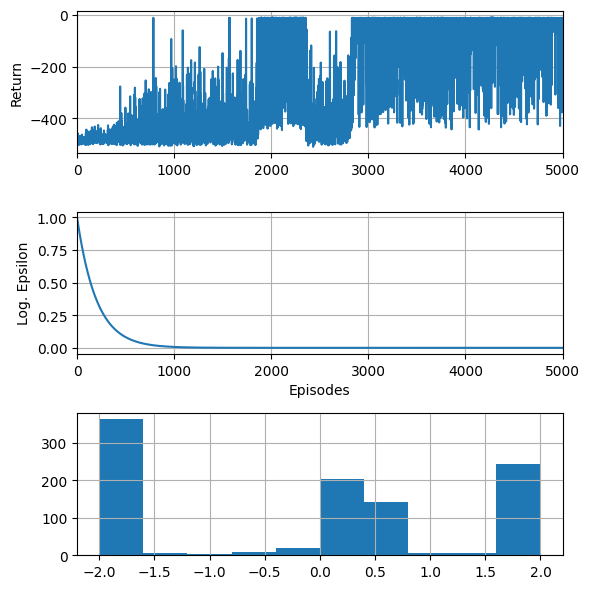

In [62]:
fig, axes = plt.subplots(3, 1, figsize=(6, 6))
axes = axes.flatten()
axes[0].plot(Gs)
axes[0].set_xlim(0, E)
axes[0].grid()
axes[0].set_ylabel("Return")
axes[1].plot(Eps)
axes[1].set_xlim(0, E)
axes[1].grid()
axes[1].set_xlabel("Episodes")
axes[1].set_ylabel("Log. Epsilon")
axes[2].hist(As[-1000:])
axes[2].grid()
plt.tight_layout()
plt.show()

In [35]:
# g = 100
for r in [1, 5, 10, 20, 50, 100]:
    factors = tl.decomposition.parafac(Q, rank=r)
    Q_hat = tl.cp_to_tensor(factors)
    err = np.linalg.norm(Q - Q_hat)
    print(f"Rank {r}: {err}")

AttributeError: module 'tensorly.backend' has no attribute 'decomposition'

In [ ]:
E = 100
H = 100
k = 50

Gs = []
factors = tl.decomposition.parafac(Q, rank=k)
Q_hat = tl.cp_to_tensor(factors)
for episode in range(E):
    G = 0
    s, _ = env.reset()
    s_idx = discretizer.get_state_index(s)
    for h in range(H):
        a_idx = Q_hat[s_idx].argmax()   
        a = discretizer.get_action_from_index(a_idx)
        s, r, d, _, _ = env.step(a)
        s_idx = discretizer.get_state_index(s)
        
        G += r
    Gs.append(G)
print(np.mean(Gs))

In [37]:
q_small = Q[::]

In [43]:
q_big = Q[::]

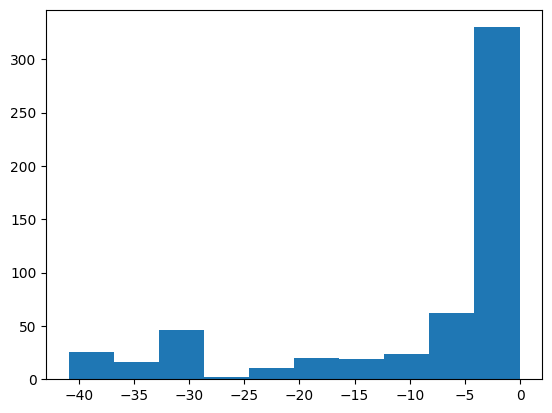

In [57]:
plt.hist(q_small[q_small < 0].flatten());

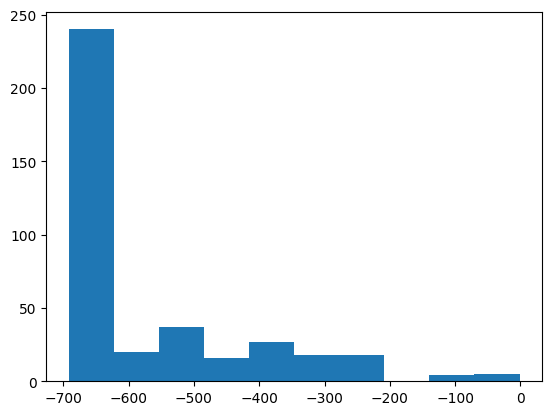

In [58]:
plt.hist(q_big[q_big < 0].flatten());

# Training - TLR

In [118]:
# g = 1 -> R = -1 [C]
# g = 20 -> R = -5 - 10 [C]
# g = 30 -> R = -5 - 10 [C]
# g = 50 -> R = -20 [C]
# g = 100 -> R = -15 - 25 [C]

In [126]:
g = 100
m = 1
l = 1
env = PendulumEnv(g, m, l)
nS = 10
nA = 10

In [127]:
discretizer = Discretizer(
    min_points_states=[-1, -5],
    max_points_states=[1, 5],
    bucket_states=[nS]*2,
    min_points_actions=[-2],
    max_points_actions=[2],
    bucket_actions=[nA],
)

In [172]:
# E = 30_000
E = 30_000
H = 100
lr = 0.0001
#eps = 1.0
eps_decay = 0.999999
eps_min = 0.0
gamma = 0.99
k = 100

def select_action(Q, s_idx, epsilon):
    if np.random.rand() < epsilon:
        idx = np.random.choice(nA)
    else:
        idx = Q(s_idx).argmax().item()
    
    a = discretizer.get_action_from_index(idx)
    return a, idx

#Gs = []
#Eps = []
#As = []
#Q = PARAFAC(dims=[nS, nS, nA], k=k, scale=1.0)
#opt = torch.optim.Adam(Q.parameters(), lr=lr)
for episode in range(E):
    G = 0
    s, _ = env.reset()
    s_idx = discretizer.get_state_index(s)
    for h in range(H):
        a, a_idx = select_action(Q, s_idx, eps)
        sp, r, d, _, _ = env.step(a)
        sp_idx = discretizer.get_state_index(sp)
        
        G += r
        
        # Update
        for factor in Q.factors:
            q_target = torch.tensor(r) + gamma * Q(sp_idx).max().detach()
            q_hat = Q(s_idx + tuple([a_idx]))
        
            opt.zero_grad()
            loss = torch.nn.MSELoss()
            loss(q_hat, q_target).backward()

            with torch.no_grad():
                for frozen_factor in Q.factors:
                    if frozen_factor is not factor:
                        frozen_factor.grad = None
            opt.step()
        
        if d:
            break
            
        s = sp
        s_idx = sp_idx
        eps = max(eps*eps_decay, eps_min)
        As.append(a[0])
    Gs.append(G)
    Eps.append(eps)

In [173]:
np.mean(Gs[-100:])

-24.817013863850708

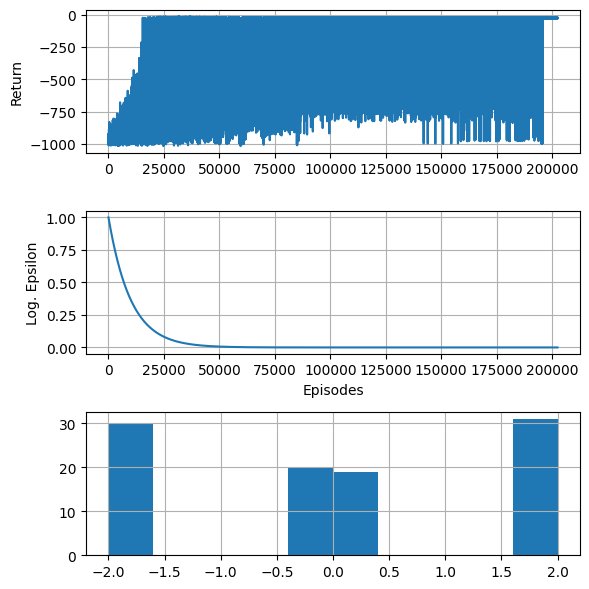

In [174]:
fig, axes = plt.subplots(3, 1, figsize=(6, 6))
axes = axes.flatten()
axes[0].plot(Gs)
#axes[0].set_xlim(0, E)
axes[0].grid()
axes[0].set_ylabel("Return")
axes[1].plot(Eps)
#axes[1].set_xlim(0, E)
axes[1].grid()
axes[1].set_xlabel("Episodes")
axes[1].set_ylabel("Log. Epsilon")
axes[2].hist(As[-100:])
axes[2].grid()
plt.tight_layout()
plt.show()

In [168]:
factors = []
for factor in Q.parameters():
    factors.append(factor.detach().numpy())

In [169]:
q_hat_single = tl.cp_to_tensor((np.ones(k), factors))
q_hat_single.shape

(10, 10, 10)

# Multi-task Training

In [8]:
envs = [
    PendulumEnv(g=1, m=1),
    PendulumEnv(g=20, m=1),
    PendulumEnv(g=30, m=1),
    PendulumEnv(g=50, m=1),
    PendulumEnv(g=100, m=1)
]
nS = 10
nA = 10
nT = len(envs)
k = 500

In [9]:
discretizer = Discretizer(
    min_points_states=[-1, -5],
    max_points_states=[1, 5],
    bucket_states=[nS]*2,
    min_points_actions=[-2],
    max_points_actions=[2],
    bucket_actions=[nA],
)

In [21]:
# SEQUENTIAL SAMPLING
E = 5_000
H = 100
lr = 0.0001
eps = 1.0
eps_decay = 0.99999
eps_min = 0.0
gamma = .99

def select_action(Q, s_idx, epsilon):
    if np.random.rand() < epsilon:
        idx = np.random.choice(nA)
    else:
        idx = Q(s_idx).argmax().item()
    
    a = discretizer.get_action_from_index(idx)
    return a, idx

Gs = []
GTs = [list() for _ in range(nT)]
ATs = [list() for _ in range(nT)]
Eps = []
Q = PARAFAC(dims=[nT, nS, nS, nA], k=k, scale=1.0)
opt = torch.optim.Adam(Q.parameters(), lr=lr)
for episode in range(E):
    for env_idx, env in enumerate(envs):
        G = 0
        s, _ = env.reset()
        s_idx = tuple([env_idx]) + discretizer.get_state_index(s)
        for h in range(H):
            a, a_idx = select_action(Q, s_idx, eps)
            sp, r, d, _, _ = env.step(a)
            sp_idx = tuple([env_idx]) + discretizer.get_state_index(sp)

            G += r

            q_target = torch.tensor(r) + gamma * Q(sp_idx).max().detach()
            q_hat = Q(s_idx + tuple([a_idx]))

            opt.zero_grad()
            loss = torch.nn.MSELoss()
            loss(q_hat, q_target).backward()
            opt.step()

            if d:
                break

            s = sp
            s_idx = sp_idx
            eps = max(eps*eps_decay, eps_min)
            
            ATs[env_idx].append(a[0])
        Gs.append(G)
        GTs[env_idx].append(G)
        Eps.append(eps)

KeyboardInterrupt: 

In [135]:
# RANDOM SAMPLING
E = 200_000
H = 100
lr = 0.00001
#eps = 1.0
eps_decay = 0.999999
eps_min = 0.0
gamma = .99

c = {
    0: 1,
    1: 1,
    2: 2,
    3: 2,
    4: 2,
}

def select_action(Q, s_idx, epsilon):
    if np.random.rand() < epsilon:
        idx = np.random.choice(nA)
    else:
        idx = Q(s_idx).argmax().item()
    
    a = discretizer.get_action_from_index(idx)
    return a, idx

#Gs = []
#GTs = [list() for _ in range(nT)]
#ATs = [list() for _ in range(nT)]
#Eps = []
#Q = PARAFAC(dims=[nT, nS, nS, nA], k=k, scale=1.0)
#opt = torch.optim.Adam(Q.parameters(), lr=lr)
for episode in range(E):
        #env_idx = np.random.choice(nT, p=[0.025, 0.025, 0.025, 0.025, 0.9])
        env_idx = np.random.choice(nT, p=[0.2, 0.2, 0.2, 0.2, 0.2])
        #env_idx = 4
        env = envs[env_idx]
        G = 0
        s, _ = env.reset()
        s_idx = tuple([env_idx]) + discretizer.get_state_index(s)
        for h in range(H):
            a, a_idx = select_action(Q, s_idx, eps)
            sp, r, d, _, _ = env.step(a)
            sp_idx = tuple([env_idx]) + discretizer.get_state_index(sp)
            
            r /= c[env_idx]

            G += r
            
            for _ in range(5):
                q_target = torch.tensor(r) + gamma * Q(sp_idx).max().detach()
                q_hat = Q(s_idx + tuple([a_idx]))

                opt.zero_grad()
                loss = torch.nn.MSELoss()
                loss(q_hat, q_target).backward()
                opt.step()

            if d:
                break

            s = sp
            s_idx = sp_idx
            eps = max(eps*eps_decay, eps_min)
            
            ATs[env_idx].append(a[0])
        Gs.append(G)
        GTs[env_idx].append(G)
        Eps.append(eps)

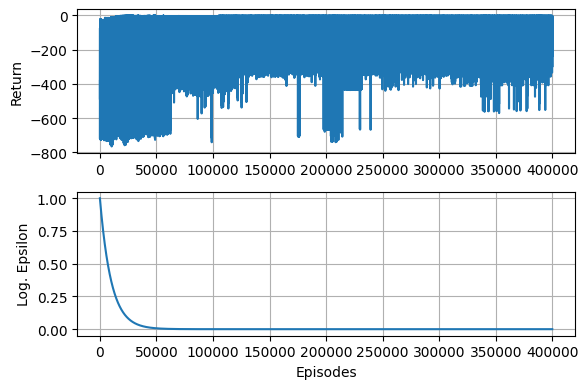

In [136]:
fig, axes = plt.subplots(2, 1, figsize=(6, 4))
axes = axes.flatten()
axes[0].plot(Gs)
#axes[0].set_xlim(0, E*nT)
axes[0].grid()
axes[0].set_ylabel("Return")
axes[1].plot(Eps)
#axes[1].set_xlim(0, E*nT)
axes[1].grid()
axes[1].set_xlabel("Episodes")
axes[1].set_ylabel("Log. Epsilon")
plt.tight_layout()
plt.show()

In [141]:
np.median([99.59274690640599, 98.47129219801604, 98.48544413677305, 97.22500013438795, 98.52602720004454, 98.22918492948274, 99.50236417300187, 97.31947857027146, 97.45603505277218, 98.29585525673544, 97.74694708101778, 97.1825232635967, 97.30870517753564, 97.55172707631046, 99.52857476910587, 98.9509313533069, 97.24379116891579, 97.69238963989295, 96.94251421449837, 98.27110296859426, 99.59608962777352, 99.57161664054004, 97.23883050832784, 97.55206550188244, 97.76643836056124, 97.52104480911815, 97.859139078769, 96.94234104632356, 97.52464641795153, 96.86064501520633, 98.12241066758638, 97.18977752088144, 98.53914322978379, 97.78296881329315, 97.72602198171839, 96.80294392743899, 97.4472639568967, 97.33366792190535, 97.12938943350032, 98.73906649483811, 97.05044630721473, 97.33127299191298, 98.42963165089209, 98.65815507225153, 99.595612747402, 99.02710167536996, 97.61095429372264, 98.07688739674082, 98.6822850322751, 99.59004071860682, 98.92575982317875, 98.53889921931672, 97.59407018078487, 97.45243424493452, 97.53701768942541, 97.5946174907724, 97.49474668284176, 97.31309252929722, 98.5222487546567, 98.53109087711657, 97.13510891101551, 99.57147597254342, 98.41011372648823, 97.52299313214532, 97.9278807320728, 98.63288106913166, 98.39055014726969, 97.54168211843917, 98.49035698760304, 98.25855326497687, 97.4519197956057, 98.05845942229082, 98.62690021834928, 97.59571469161645, 97.27620010274102, 98.49625308086482, 96.22962813482908, 96.9429691135367, 96.90580923919411, 97.0534110410162, 98.27848595937627, 98.56301144695605, 98.02287901755383, 97.35671804417987, 97.4523995543771, 99.58808681878335, 97.20901297588274, 97.11851516871023, 98.14430053405428, 97.02255139613108, 97.44634351938879, 99.57030453205277, 97.5201474379148, 97.23434731122963, 98.48064404619464, 97.19067604122577, 97.67099425583432, 97.85850201229945, 97.44700054211864, 98.81566528589])

97.70920581080567

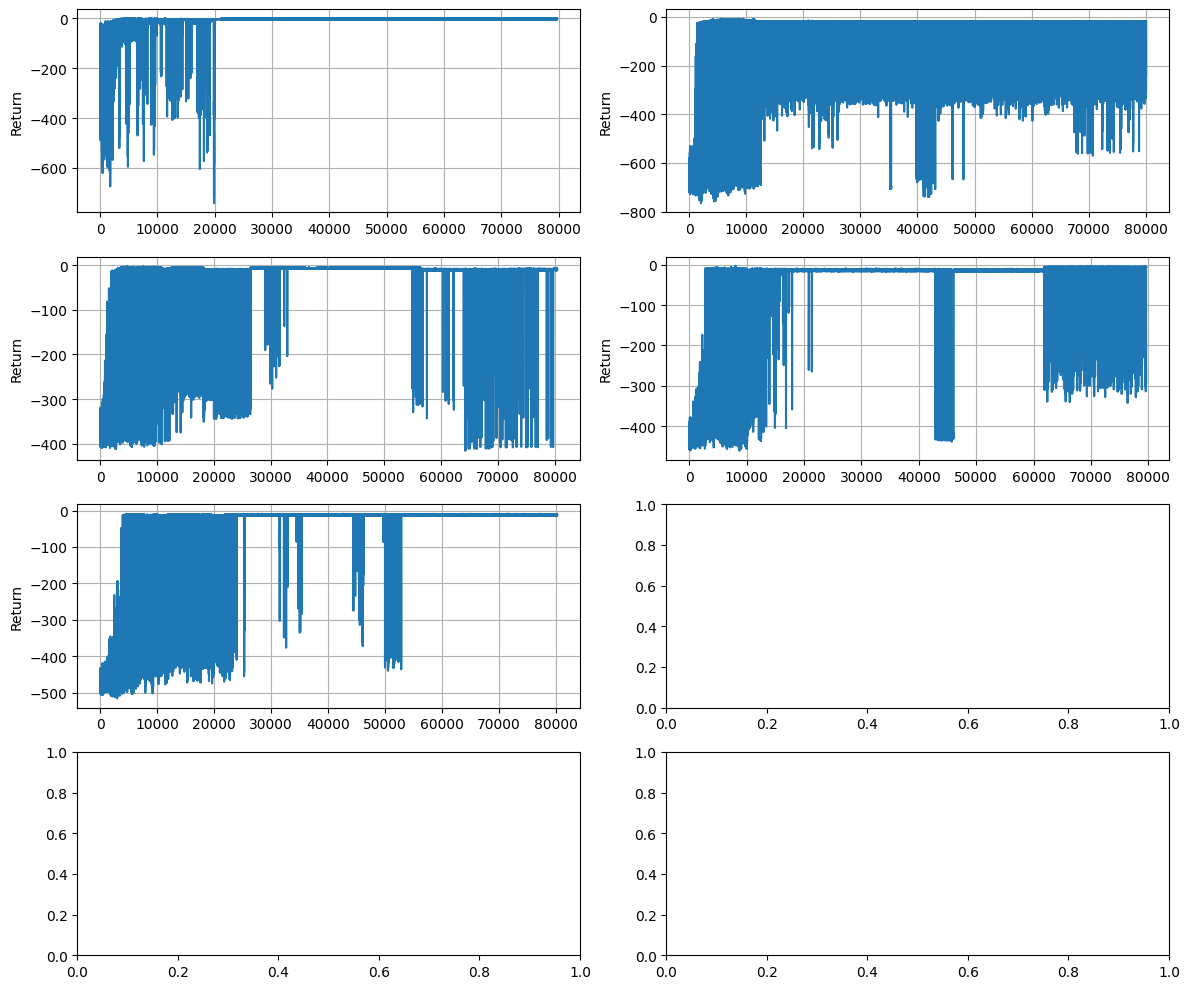

In [137]:
fig, axes = plt.subplots(4, 2, figsize=(12, 2*nT))
axes = axes.flatten()
for i in range(nT):
    #axes[i].set_title(f"Mass: {masses[i]}")
    axes[i].plot(GTs[i])
    #axes[i].set_xlim(0, E)
    axes[i].grid()
    axes[i].set_ylabel("Return")
plt.tight_layout()
plt.show()

# 5 10 100
# Q.shape -> 10 x 10 x 10 x 5
# i j k z
# max_rank min prod(ijk), prod(ikz) ...

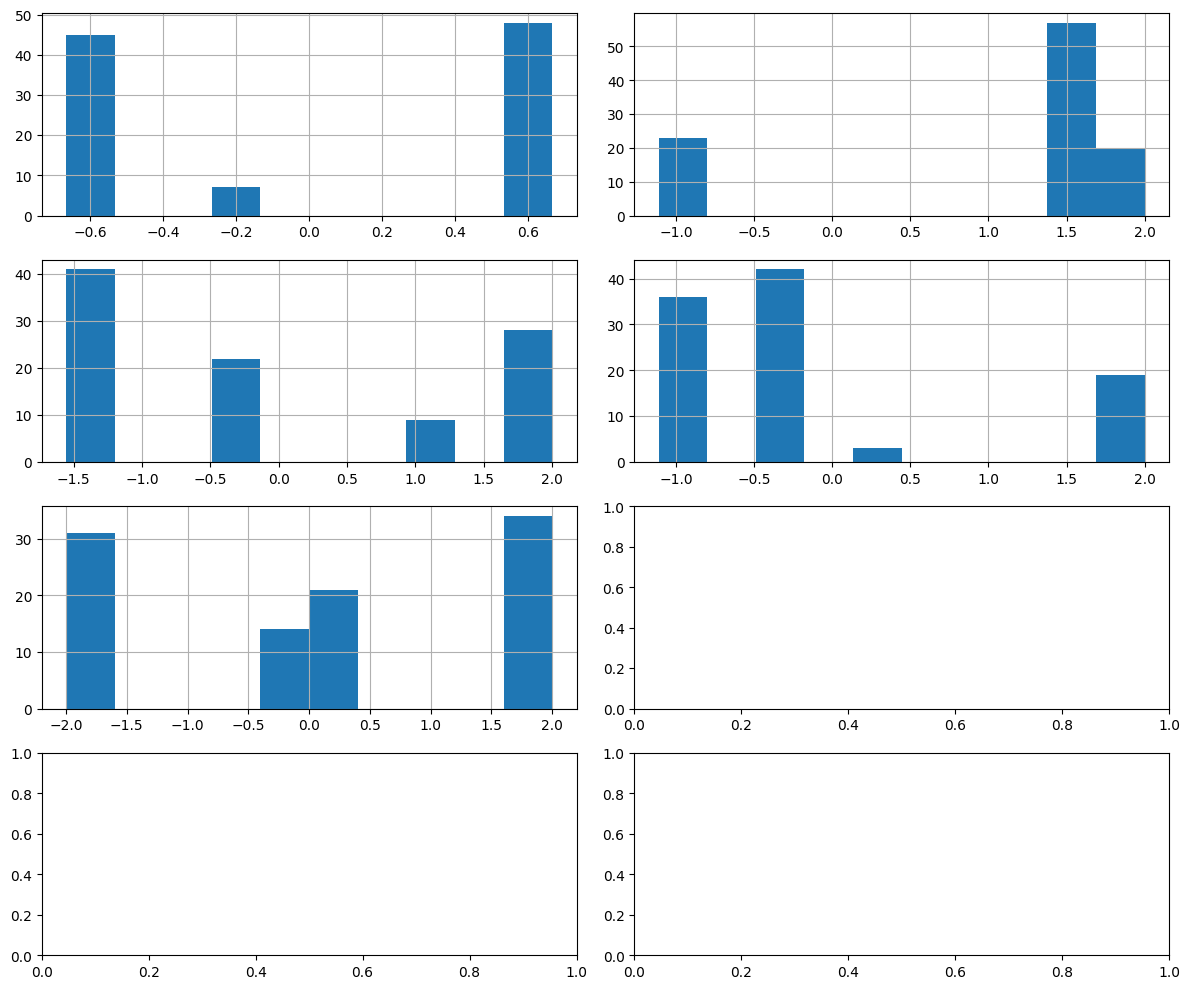

In [138]:
fig, axes = plt.subplots(4, 2, figsize=(12, 2*nT))
axes = axes.flatten()
for i in range(nT):
    #axes[i].set_title(f"Mass: {masses[i]}")
    axes[i].hist(ATs[i][-100:])
    axes[i].grid()
plt.tight_layout()
plt.show()

In [139]:
for i in range(nT):
    print(np.median(GTs[i][-100:]))

-3.754136175916105
-17.67913982742261
-9.499649008231739
-6.175392434392901
-12.579301644492968


In [107]:
factors = []
for factor in Q.parameters():
    factors.append(factor.detach().numpy())

In [91]:
# q_hat_multi = tl.cp_to_tensor((np.ones(10), factors))
# q_hat_multi.shape

# Second try

In [373]:
# RANDOM SAMPLING
E = 200_000
H = 100
lr = 0.00001
eps = 1.0
eps_decay = 0.999999
eps_min = 0.0
gamma = .99

def select_action(Q, s_idx, epsilon):
    if np.random.rand() < epsilon:
        idx = np.random.choice(nA)
    else:
        idx = Q(s_idx).argmax().item()
    
    a = discretizer.get_action_from_index(idx)
    return a, idx

Gs = []
GTs = [list() for _ in range(nT)]
ATs = [list() for _ in range(nT)]
Eps = []
Q = PARAFAC(dims=[nT, nS, nS, nA], k=k, scale=1.0)
opt = torch.optim.Adam(Q.parameters(), lr=lr)
for episode in range(E):
        env_idx = np.random.choice(nT, p=[0.2, 0.2, 0.2, 0.2, 0.2])
        env = envs[env_idx]
        G = 0
        s, _ = env.reset()
        s_idx = tuple([env_idx]) + discretizer.get_state_index(s)
        for h in range(H):
            a, a_idx = select_action(Q, s_idx, eps)
            sp, r, d, _, _ = env.step(a)
            sp_idx = tuple([env_idx]) + discretizer.get_state_index(sp)

            G += r
            
            for _ in range(10):
                q_target = torch.tensor(r) + gamma * Q(sp_idx).max().detach()
                q_hat = Q(s_idx + tuple([a_idx]))

                opt.zero_grad()
                loss = torch.nn.MSELoss()
                loss(q_hat, q_target).backward()
                opt.step()

            if d:
                break

            s = sp
            s_idx = sp_idx
            eps = max(eps*eps_decay, eps_min)
            
            ATs[env_idx].append(a[0])
        Gs.append(G)
        GTs[env_idx].append(G)
        Eps.append(eps)

KeyboardInterrupt: 

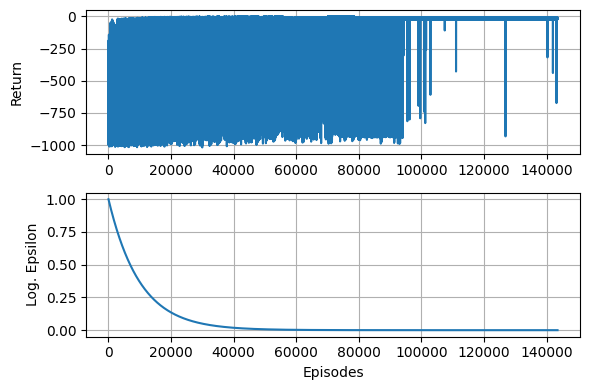

In [374]:
fig, axes = plt.subplots(2, 1, figsize=(6, 4))
axes = axes.flatten()
axes[0].plot(Gs)
#axes[0].set_xlim(0, E*nT)
axes[0].grid()
axes[0].set_ylabel("Return")
axes[1].plot(Eps)
#axes[1].set_xlim(0, E*nT)
axes[1].grid()
axes[1].set_xlabel("Episodes")
axes[1].set_ylabel("Log. Epsilon")
plt.tight_layout()
plt.show()

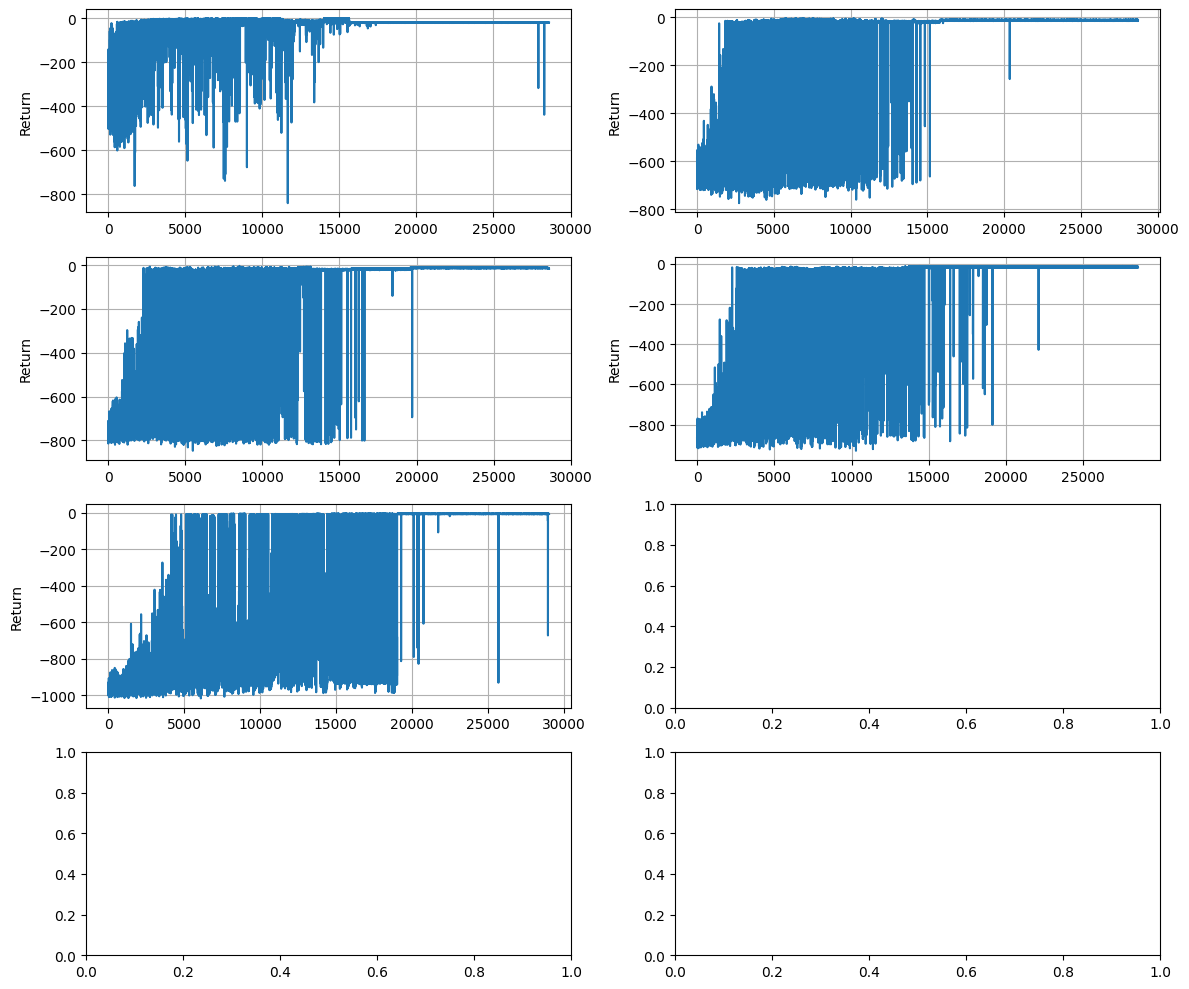

In [375]:
fig, axes = plt.subplots(4, 2, figsize=(12, 2*nT))
axes = axes.flatten()
for i in range(nT):
    #axes[i].set_title(f"Mass: {masses[i]}")
    axes[i].plot(GTs[i])
    #axes[i].set_xlim(0, E)
    axes[i].grid()
    axes[i].set_ylabel("Return")
plt.tight_layout()
plt.show()

# 5 10 100
# Q.shape -> 10 x 10 x 10 x 5
# i j k z
# max_rank min prod(ijk), prod(ikz) ...

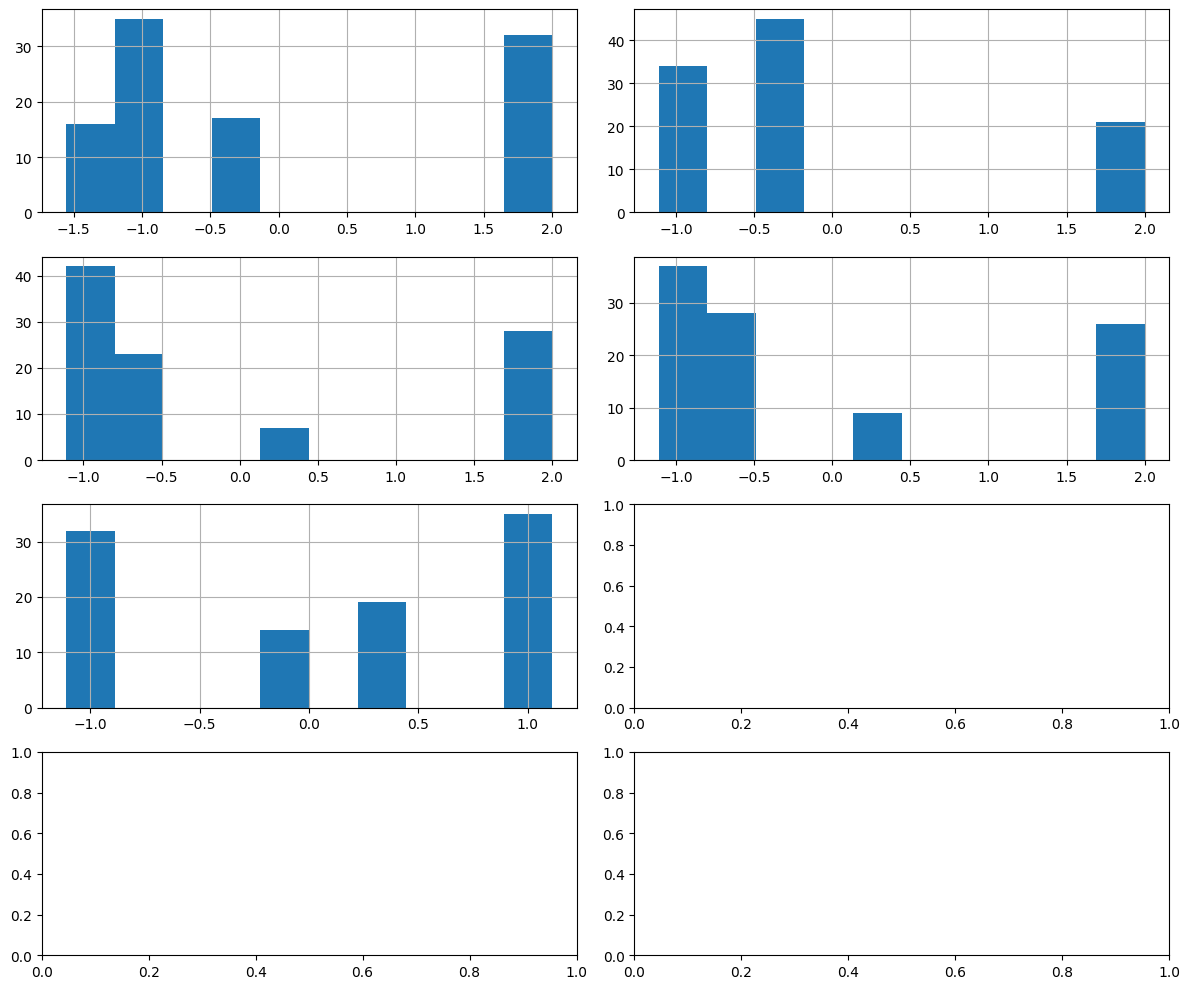

In [376]:
fig, axes = plt.subplots(4, 2, figsize=(12, 2*nT))
axes = axes.flatten()
for i in range(nT):
    #axes[i].set_title(f"Mass: {masses[i]}")
    axes[i].hist(ATs[i][-100:])
    axes[i].grid()
plt.tight_layout()
plt.show()

In [377]:
for i in range(nT):
    print(np.median(GTs[i][-100:]))

-21.32579951888009
-12.217605675578518
-15.294918340689772
-15.18465877870457
-7.876008630960715


# Third try

In [24]:
# RANDOM SAMPLING
E = 200_000
H = 100
lr = 0.00001
#eps = 1.0
eps_decay = 0.999999
eps_min = 0.0
gamma = .99
k = 200

def select_action(Q, s_idx, epsilon):
    if np.random.rand() < epsilon:
        idx = np.random.choice(nA)
    else:
        idx = Q(s_idx).argmax().item()
    
    a = discretizer.get_action_from_index(idx)
    return a, idx

#Gs = []
#GTs = [list() for _ in range(nT)]
#ATs = [list() for _ in range(nT)]
#Eps = []
#Q = PARAFAC(dims=[nT, nS, nS, nA], k=k, scale=1.0)
#opt = torch.optim.Adam(Q.parameters(), lr=lr)
for episode in range(E):
        env_idx = np.random.choice(nT, p=[0.2, 0.2, 0.2, 0.2, 0.2])
        env = envs[env_idx]
        G = 0
        s, _ = env.reset()
        s_idx = tuple([env_idx]) + discretizer.get_state_index(s)
        for h in range(H):
            a, a_idx = select_action(Q, s_idx, eps)
            sp, r, d, _, _ = env.step(a)
            sp_idx = tuple([env_idx]) + discretizer.get_state_index(sp)

            G += r
            
            for _ in range(10):
                q_target = torch.tensor(r) + gamma * Q(sp_idx).max().detach()
                q_hat = Q(s_idx + tuple([a_idx]))

                opt.zero_grad()
                loss = torch.nn.MSELoss()
                loss(q_hat, q_target).backward()
                opt.step()

            if d:
                break

            s = sp
            s_idx = sp_idx
            eps = max(eps*eps_decay, eps_min)
            
            ATs[env_idx].append(a[0])
        Gs.append(G)
        GTs[env_idx].append(G)
        Eps.append(eps)

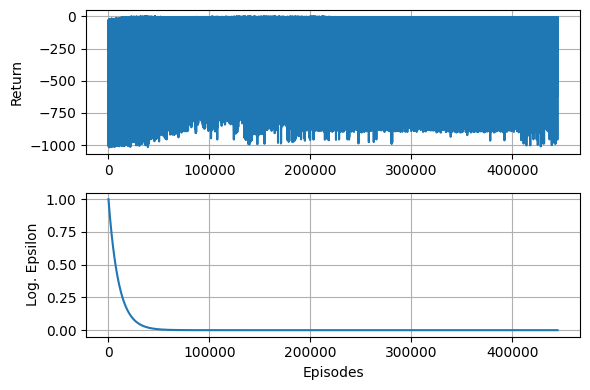

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(6, 4))
axes = axes.flatten()
axes[0].plot(Gs)
#axes[0].set_xlim(0, E*nT)
axes[0].grid()
axes[0].set_ylabel("Return")
axes[1].plot(Eps)
#axes[1].set_xlim(0, E*nT)
axes[1].grid()
axes[1].set_xlabel("Episodes")
axes[1].set_ylabel("Log. Epsilon")
plt.tight_layout()
plt.show()

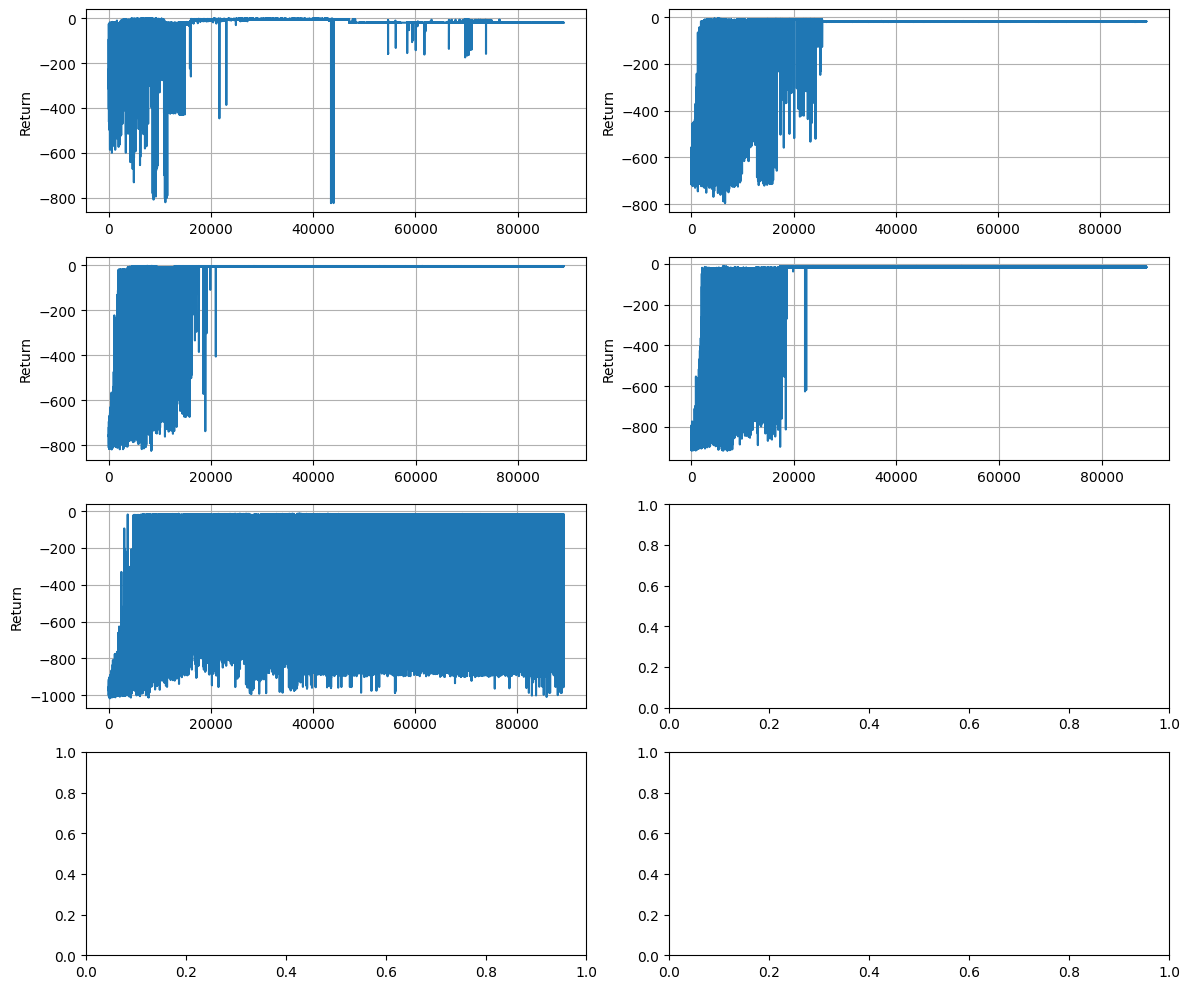

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(12, 2*nT))
axes = axes.flatten()
for i in range(nT):
    #axes[i].set_title(f"Mass: {masses[i]}")
    axes[i].plot(GTs[i])
    #axes[i].set_xlim(0, E)
    axes[i].grid()
    axes[i].set_ylabel("Return")
plt.tight_layout()
plt.show()

# 5 10 100
# Q.shape -> 10 x 10 x 10 x 5
# i j k z
# max_rank min prod(ijk), prod(ikz) ...

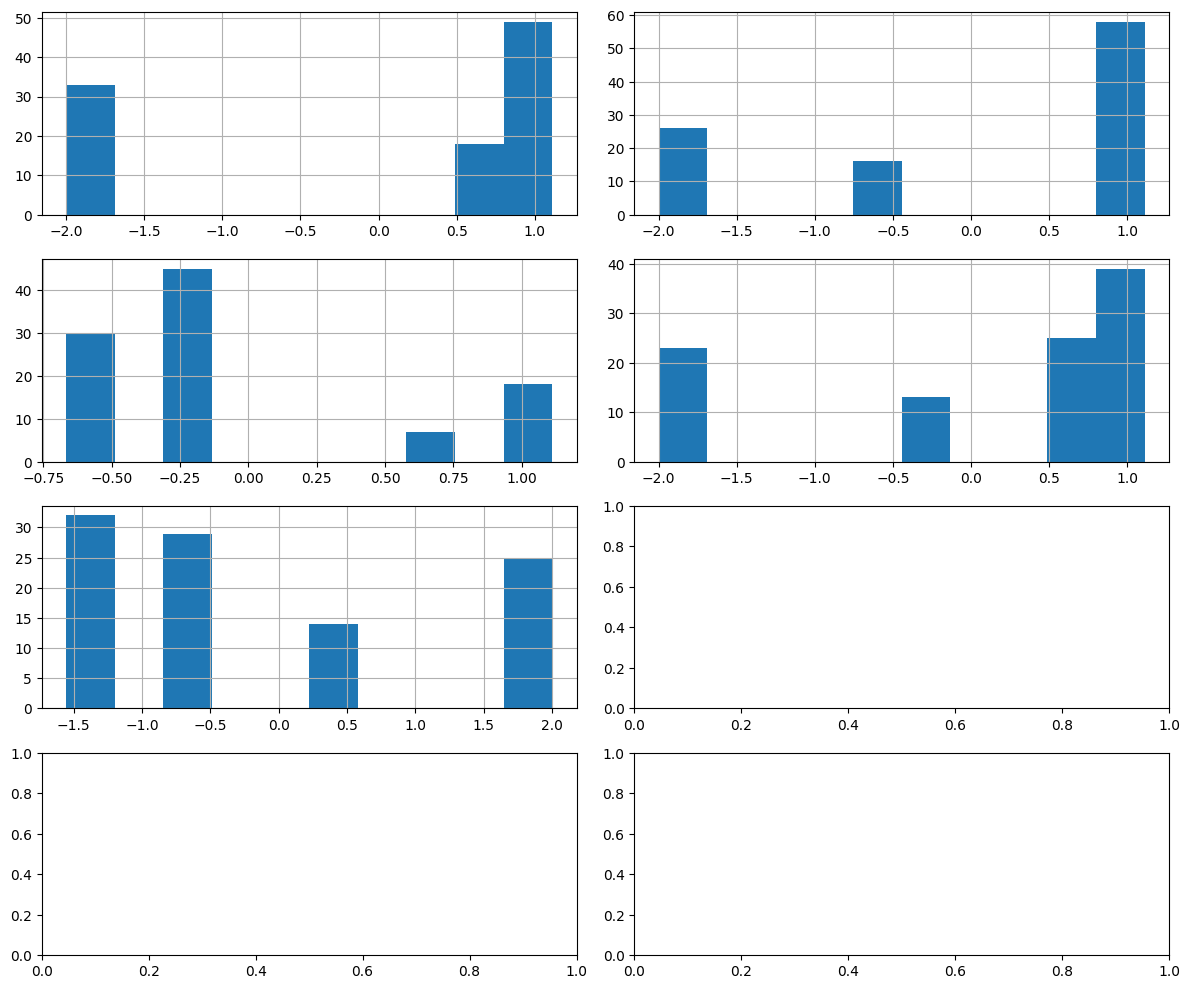

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(12, 2*nT))
axes = axes.flatten()
for i in range(nT):
    #axes[i].set_title(f"Mass: {masses[i]}")
    axes[i].hist(ATs[i][-100:])
    axes[i].grid()
plt.tight_layout()
plt.show()

In [ ]:
for i in range(nT):
    print(np.median(GTs[i][-100:]))

-20.265410659449074
-19.042863361329747
-4.797742732458435
-15.015044027083109
-21.1478060820264


# Multi-task Training Single Agent

In [210]:
envs = [
    PendulumEnv(g=1, m=1),
    PendulumEnv(g=5, m=1),
    PendulumEnv(g=5, m=5),
    PendulumEnv(g=10, m=10)
]
nS = 10
nA = 10
nT = len(envs)
k = 100

In [211]:
discretizer = Discretizer(
    min_points_states=[-1, -5],
    max_points_states=[1, 5],
    bucket_states=[nS]*2,
    min_points_actions=[-2],
    max_points_actions=[2],
    bucket_actions=[nA],
)

In [216]:
E = 10_000
H = 100
lr = 0.0001
eps = 1.0
eps_decay = 0.999999
eps_min = 0.0
gamma = 0.99

def select_action(Q, s_idx, epsilon):
    if np.random.rand() < epsilon:
        idx = np.random.choice(nA)
    else:
        idx = Q(s_idx).argmax().item()
    
    a = discretizer.get_action_from_index(idx)
    return a, idx

Gs = []
GTs = [list() for _ in range(nT)]
ATs = [list() for _ in range(nT)]
Eps = []
Q = PARAFAC(dims=[nS, nS, nS, nS, nA], k=k, scale=1.0)
opt = torch.optim.Adam(Q.parameters(), lr=lr)
for episode in range(E):
    for env_idx, env in enumerate(envs):
        G = 0
        s, _ = env.reset()
        s_idx = discretizer.get_state_index(s)
        for h in range(H):
            a, a_idx = select_action(Q, s_idx, eps)
            sp, r, d, _, _ = env.step(a)
            sp_idx = discretizer.get_state_index(sp)

            G += r

            m = -1*(d - 1)
            q_target = torch.tensor(r) + gamma * m * Q(sp_idx).max().detach()
            q_hat = Q(s_idx + tuple([a_idx]))

            opt.zero_grad()
            loss = torch.nn.MSELoss()
            loss(q_hat, q_target).backward()
            opt.step()

            if d:
                break

            s = sp
            s_idx = sp_idx
            eps = max(eps*eps_decay, eps_min)
            
            ATs[env_idx].append(a[0])
        Gs.append(G)
        GTs[env_idx].append(G)
        Eps.append(eps)

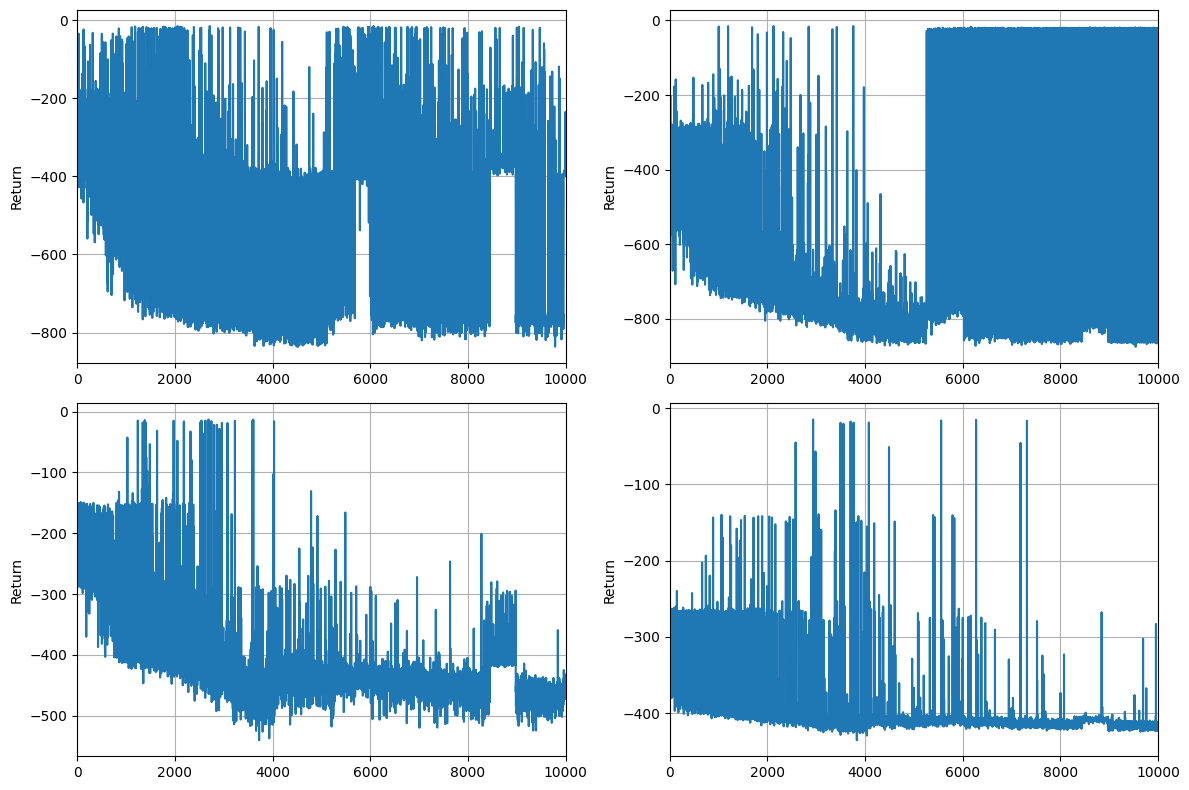

In [217]:
fig, axes = plt.subplots(2, 2, figsize=(12, 2*nT))
axes = axes.flatten()
for i in range(nT):
    #axes[i].set_title(f"Mass: {masses[i]}")
    axes[i].plot(GTs[i])
    axes[i].set_xlim(0, E)
    axes[i].grid()
    axes[i].set_ylabel("Return")
plt.tight_layout()
plt.show()

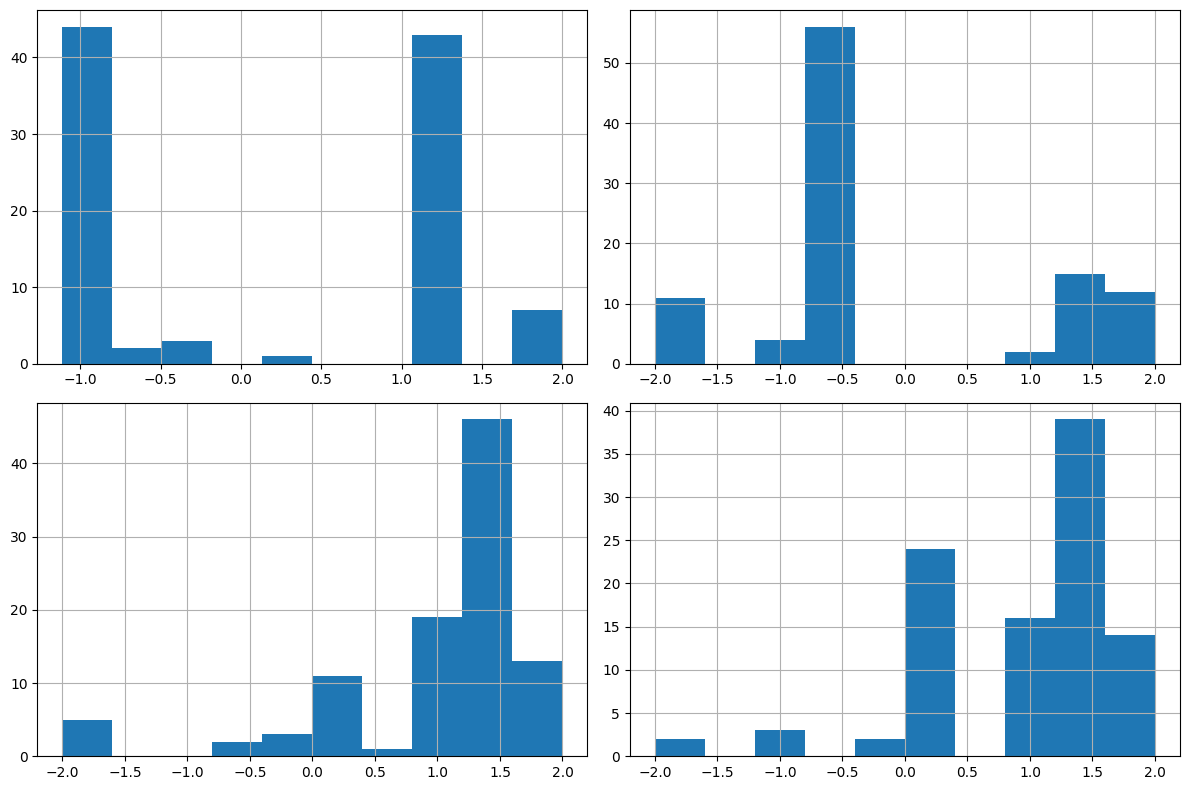

In [218]:
fig, axes = plt.subplots(2, 2, figsize=(12, 2*nT))
axes = axes.flatten()
for i in range(nT):
    #axes[i].set_title(f"Mass: {masses[i]}")
    axes[i].hist(ATs[i][-100:])
    axes[i].grid()
plt.tight_layout()
plt.show()

In [219]:
np.mean(GTs[0][-100:]), np.mean(GTs[1][-100:]), np.mean(GTs[2][-100:]), np.mean(GTs[3][-100:])

(-619.9959007835935,
 -363.58987073645864,
 -462.9003106137505,
 -415.06683602287836)

TODOs:
- probar otros tipos de sampling -> muestrear más el entorno más complicado
- utilizar las muestras para hacer más pasos de gradiente
- pensar en como acomodar los márgenes dinámicos